In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve,auc,average_precision_score
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv(r'/content/drive/MyDrive/ColabNotebooks/Loan_Defaulter_Prediction/new_spark_cleaned_data.csv')

In [6]:
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,EmploymentType,...,LoanPurpose_Other,LoanPurpose_Auto,LoanPurpose_Business,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Divorced,Education_HighSchool,Education_Bachelor,Education_Master,Education_PhD
0,56,85994,50587,520,80,4,15.23,36,0.44,2,...,1,0,0,0,0,1,0,1,0,0
1,69,50432,124440,458,15,1,4.81,60,0.68,2,...,1,0,0,1,0,0,0,0,1,0
2,46,84208,129188,451,26,3,21.17,24,0.31,0,...,0,1,0,0,0,1,0,0,1,0
3,32,31713,44799,743,0,3,7.07,24,0.23,2,...,0,0,1,1,0,0,1,0,0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0,...,0,1,0,0,0,1,0,1,0,0


In [7]:
df.shape

(255347, 27)

In [8]:
# Separate features and target
X = df.drop('Default', axis=1)
y = df['Default']

In [9]:
# Apply SMOTETomek to training data only and balancing data
smote = SMOTETomek(sampling_strategy='minority', random_state=7)
X_smt, y_smt = smote.fit_resample(X, y)
print("✅ Data balanced using SMOTETomek")
print("Original class distribution:\n", y.value_counts())
print("New class distribution:\n", y_smt.value_counts())

✅ Data balanced using SMOTETomek
Original class distribution:
 Default
0    225694
1     29653
Name: count, dtype: int64
New class distribution:
 Default
0    214298
1    214298
Name: count, dtype: int64


In [10]:
X_smt.shape, y_smt.shape

((428596, 26), (428596,))

In [11]:
pd.DataFrame(X_smt).duplicated().sum()

np.int64(0)

In [12]:
pd.DataFrame(X_smt).drop_duplicates(inplace=True)

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_smt, y_smt, test_size=0.3, random_state=7,stratify=y_smt)

In [14]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (300017, 26)
Shape of X_test: (128579, 26)
Shape of y_train: (300017,)
Shape of y_test: (128579,)


In [15]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Define classifiers
models = {
    "Logistic Regression": LogisticRegression(
        penalty='elasticnet',
        C=1.0,
        solver='saga',
        max_iter=1000,
        class_weight='balanced',
        l1_ratio=0.5
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        random_state=7
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        min_samples_split=2,
        min_samples_leaf=1,
        subsample=1.0,
        max_features='sqrt',
        random_state=7
    ),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        learning_rate=0.1,
        n_estimators=100,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        reg_alpha=0,
        reg_lambda=1,
        use_label_encoder=False,
        random_state=7
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=-1,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=0,
        random_state=7
    )
}

In [17]:
# Train & evaluate each model
for name, model in models.items():
    print(f"\n🔍 {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)

    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC Score: {auc_score:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)


🔍 Logistic Regression
Accuracy: 0.9273
ROC AUC Score: 0.9642
Confusion Matrix:
 [[63882   407]
 [ 8935 55355]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93     64289
           1       0.99      0.86      0.92     64290

    accuracy                           0.93    128579
   macro avg       0.93      0.93      0.93    128579
weighted avg       0.93      0.93      0.93    128579


🔍 Random Forest
Accuracy: 0.9309
ROC AUC Score: 0.9680
Confusion Matrix:
 [[63846   443]
 [ 8437 55853]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93     64289
           1       0.99      0.87      0.93     64290

    accuracy                           0.93    128579
   macro avg       0.94      0.93      0.93    128579
weighted avg       0.94      0.93      0.93    128579


🔍 Gradient Boosting
Accuracy: 0.9237
ROC AUC Score: 0.9613
Confusion Matrix:
 [

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:59:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9265
ROC AUC Score: 0.9638
Confusion Matrix:
 [[63973   316]
 [ 9130 55160]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93     64289
           1       0.99      0.86      0.92     64290

    accuracy                           0.93    128579
   macro avg       0.93      0.93      0.93    128579
weighted avg       0.93      0.93      0.93    128579


🔍 LightGBM
[LightGBM] [Info] Number of positive: 150008, number of negative: 150009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 300017, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000007
[LightGBM] [Info] Start training from score -0.000007


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9317
ROC AUC Score: 0.9668
Confusion Matrix:
 [[63820   469]
 [ 8308 55982]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.94     64289
           1       0.99      0.87      0.93     64290

    accuracy                           0.93    128579
   macro avg       0.94      0.93      0.93    128579
weighted avg       0.94      0.93      0.93    128579



# Initialize ROC and PR plots

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:03:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 150008, number of negative: 150009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 300017, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000007
[LightGBM] [Info] Start training from score -0.000007


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


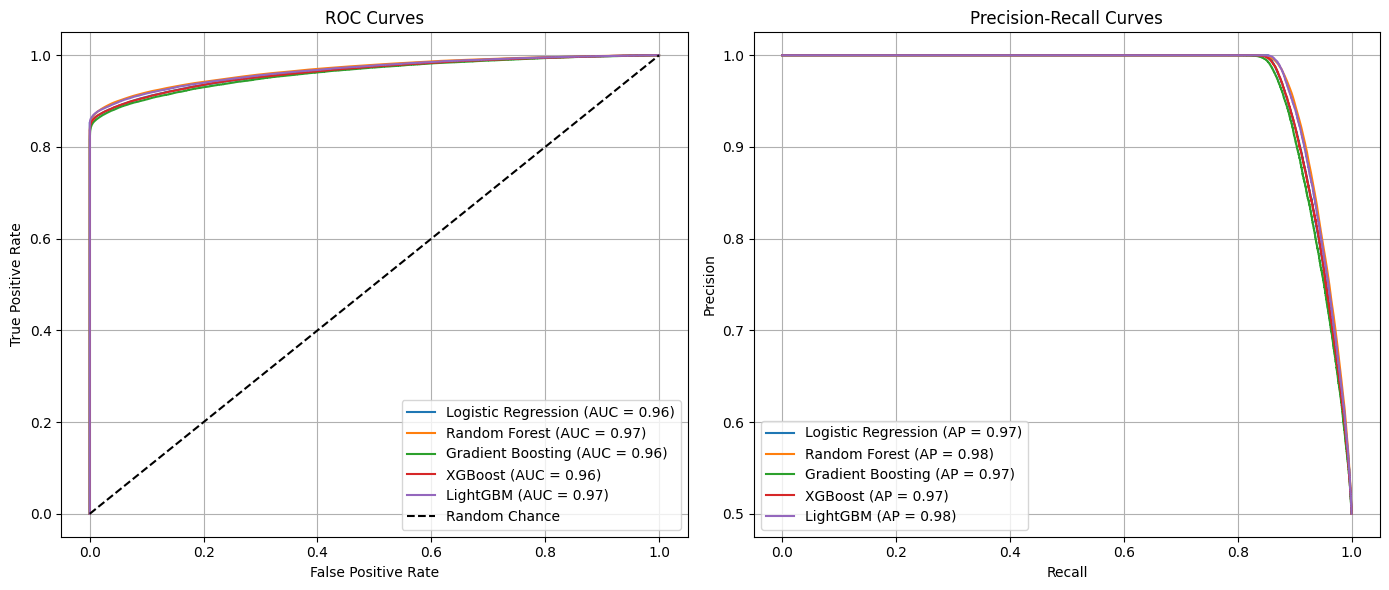

In [18]:
# Initialize ROC and PR plots
plt.figure(figsize=(14, 6))

# ----------------------
# Plot ROC Curves
# ----------------------
plt.subplot(1, 2, 1)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid()

# ----------------------
# Plot Precision-Recall Curves
# ----------------------
plt.subplot(1, 2, 2)
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f'{name} (AP = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


# Feature Importance

In [19]:
model=RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        bootstrap=True,
        random_state=7
    )
model.fit(X_test, y_test)

RandomForestClassifier(random_state=7)

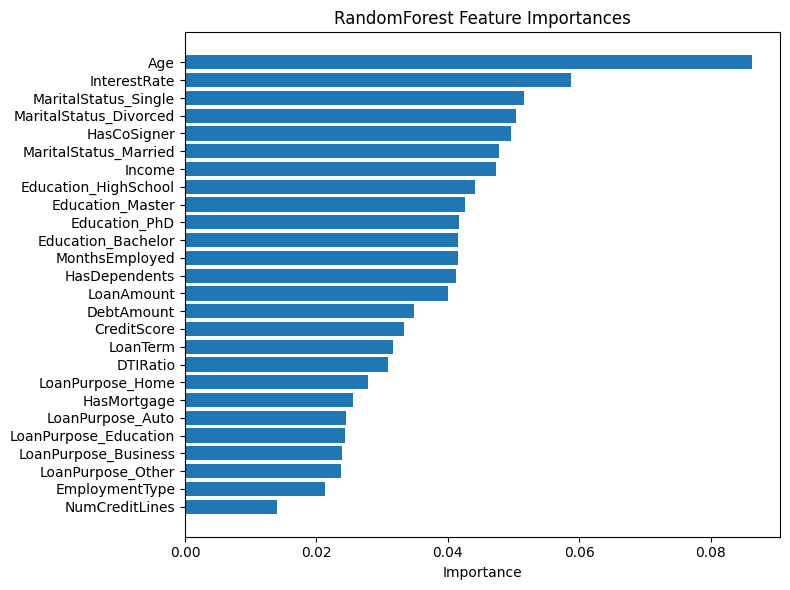

In [20]:
# Now get feature importances
importances = model.feature_importances_
feature_names = X.columns
sorted_idx = importances.argsort()

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("RandomForest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [21]:
model=LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=-1,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0,
        reg_lambda=0,
        random_state=7
    )
model.fit(X_test, y_test)

[LightGBM] [Info] Number of positive: 64290, number of negative: 64289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 128579, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500004 -> initscore=0.000016
[LightGBM] [Info] Start training from score 0.000016


LGBMClassifier(colsample_bytree=0.8, random_state=7, reg_alpha=0, reg_lambda=0,
               subsample=0.8)

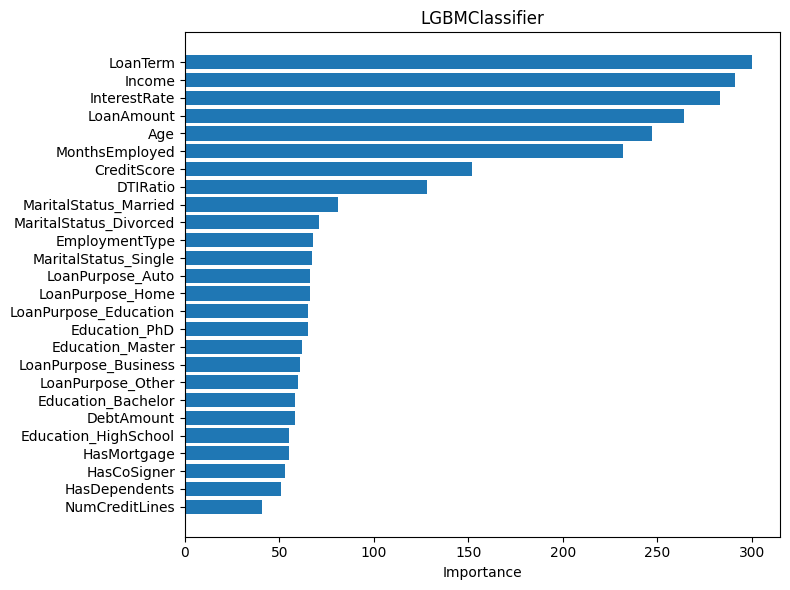

In [22]:
# Now get feature importances
importances = model.feature_importances_
feature_names = X.columns
sorted_idx = importances.argsort()

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("LGBMClassifier")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Bar Chart Comparing Accuracy & AUC of All Models

In [24]:
import seaborn as sns

In [25]:
# Initialize lists to store metrics
model_names = []
accuracies = []
auc_scores = []

In [26]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    model_names.append(name)
    accuracies.append(acc)
    auc_scores.append(auc)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:10:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 150008, number of negative: 150009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 300017, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000007
[LightGBM] [Info] Start training from score -0.000007


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [27]:
# Create DataFrame for plotting
metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'AUC': auc_scores
})

<Figure size 1000x600 with 0 Axes>

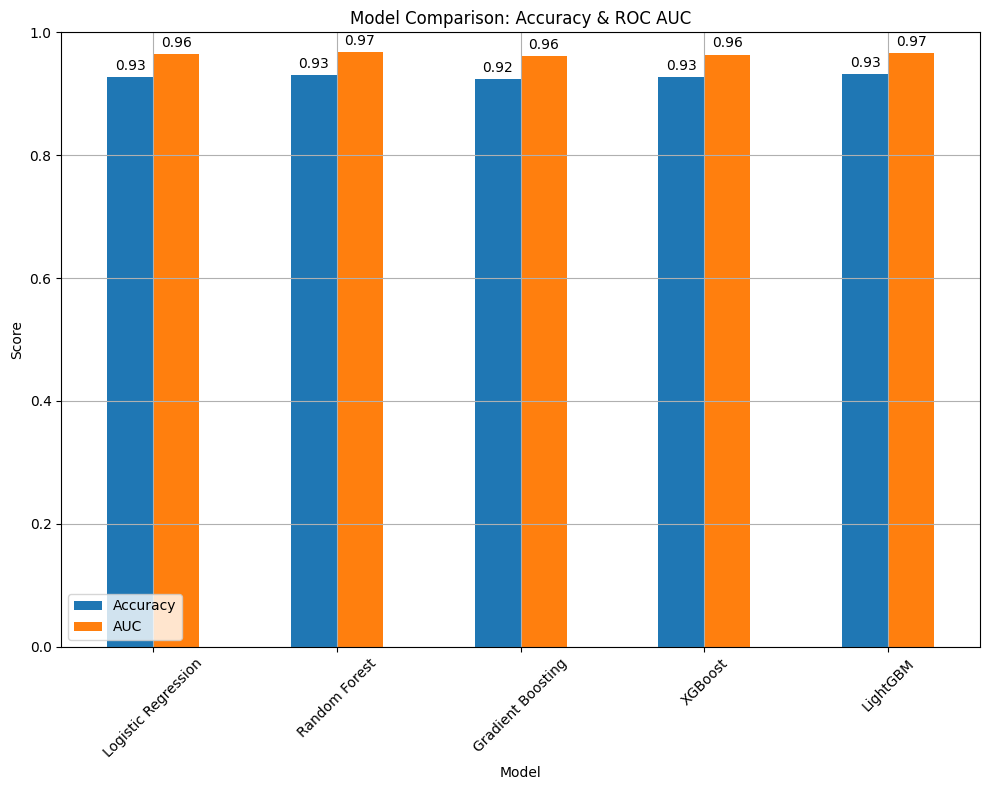

In [32]:
# Plot Accuracy & AUC side-by-side
plt.figure(figsize=(10, 6))
ax = metrics_df.set_index("Model")[["Accuracy", "AUC"]].plot(kind='bar', figsize=(10, 8))
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f',label_type='edge',padding=3)
plt.title("Model Comparison: Accuracy & ROC AUC")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

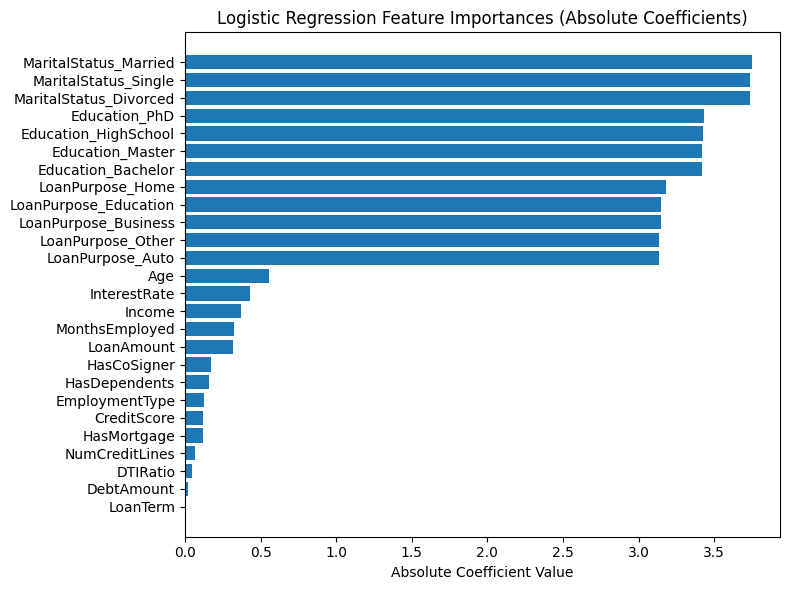

In [23]:
# Get feature importances for Logistic Regression
log_reg_model = models["Logistic Regression"]

# Get coefficients and feature names
coefficients = log_reg_model.coef_[0]
feature_names = X.columns
sorted_idx = abs(coefficients).argsort()

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), abs(coefficients)[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.title("Logistic Regression Feature Importances (Absolute Coefficients)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


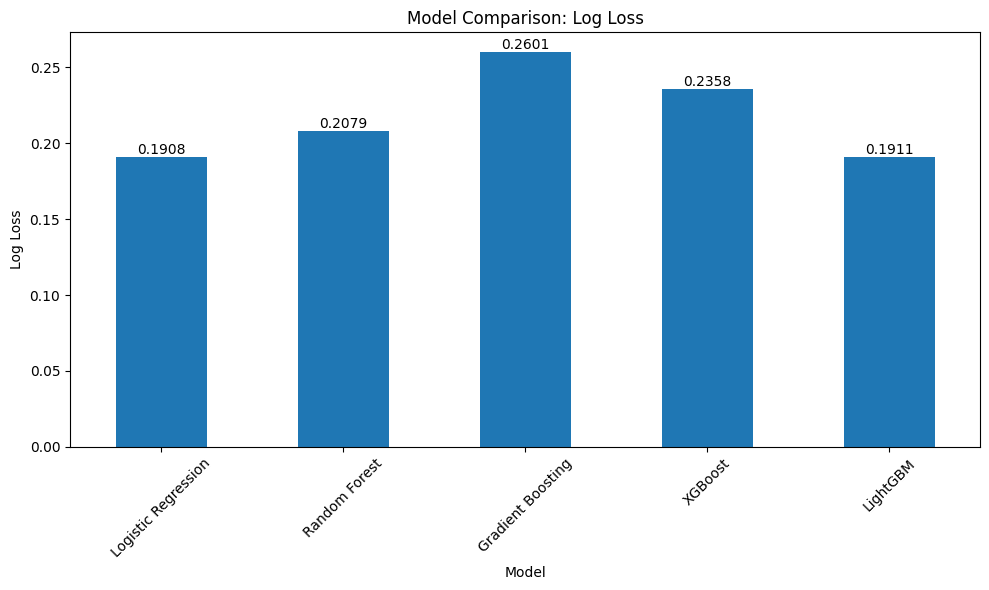

In [33]:
from sklearn.metrics import log_loss

# Initialize lists to store metrics
model_names_logloss = []
logloss_scores = []

for name, model in models.items():
    # Predict probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Calculate Log Loss
    ll = log_loss(y_test, y_proba)

    model_names_logloss.append(name)
    logloss_scores.append(ll)

# Create DataFrame for plotting
logloss_df = pd.DataFrame({
    'Model': model_names_logloss,
    'LogLoss': logloss_scores
})

# Plot Log Loss
plt.figure(figsize=(10, 6))
ax = logloss_df.set_index("Model")["LogLoss"].plot(kind='bar')
plt.title("Model Comparison: Log Loss")
plt.ylabel("Log Loss")
plt.xticks(rotation=45)

# Add values on top of bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [34]:
import pickle

# Assuming 'models' dictionary contains the trained LightGBM model
lgbm_model = models["LightGBM"]

# Define the filename for the pickle file
filename = 'lgbm_model.pkl'

# Save the model to the pickle file
with open(filename, 'wb') as f:
    pickle.dump(lgbm_model, f)

print(f"LightGBM model saved to {filename}")

LightGBM model saved to lgbm_model.pkl
